# Volatility Forecasting with GARCH: A Study on EMB ETF


## Installing and importing packages, mounting drive


In [ ]:
# import required packages

# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

# Fetch data from Yahoo Finance
import yfinance as yf
import os

# Import files from Github
import requests
from io import BytesIO

# Time series
from arch import arch_model
from hmmlearn.hmm import GaussianHMM # Hidden Markov Model
from statsmodels.tsa.stattools import adfuller # ADF test
from statsmodels.stats.diagnostic import het_arch # ARCH-LM test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF plot
import scipy.stats as stats
from scipy.stats import shapiro # Shapiro-Wilk test
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box test

# interactive plots
import plotly.express as px

## Introduction

In this analysis, I focus on modeling and forecasting market volatility using traditional time-series methods such as GARCH, and structural approaches such as Hidden Markov Models (HMMs). The selected financial instrument is the **iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)**, which provides exposure to sovereign debt issued by emerging market economies.

### GARCH models

The focus on GARCH models stems from their flexibility in capturing time-varying volatility, a limitation found in commonly used ARIMA models that assume constant volatility (homoskedasticity).\
This assumption can be restrictive in financial time-series modeling, as volatility tends to exhibit sudden spikes and regime shifts, which ARIMA models struggle to account for.\
Consequently, portions of the market movement remain unexplained.\
To validate this premise, I will first conduct homoskedasticity tests on the time series data before applying heteroskedastic models like GARCH.\
This approach ensures that the selected model effectively captures volatility clustering, which is a key characteristic in financial markets.\
GARCH models track past price movements and use them to predict how volatile markets might be further in the future; the most basic form of the model, the GARCH(1,1), models conditional variance on:

- 1: last period volatility
- 1: last period squared returns

and the conditional variance would then be written as:

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

My aim is thus to estimate the parameters $\omega$, $\alpha$, and $\beta$ of a GARCH(p,q) model, which govern the baseline variance, the impact of recent shocks, and the persistence of volatility over time.

### Hidden Markov Models (HMM)

While GARCH models assume a smooth and continuous evolution of volatility, financial markets often display abrupt regime changes due to macroeconomic shocks or shifts in investor sentiment. These structural breaks are difficult to model with continuous variance processes.

To account for such behavior, I introduce Hidden Markov Models, where log-returns are modeled as being generated from a mixture of Gaussian distributions associated with latent (unobservable) volatility regimes. Transitions between regimes are governed by a Markov chain, capturing the probabilistic nature of regime switching.

This allows for the detection of distinct states (e.g., low vs. high volatility) and provides an alternative to conditional variance modeling by explicitly segmenting the return dynamics.

### EMB ETF: Emerging Markets

The **iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)** is a widely tracked financial instrument providing exposure to **sovereign debt issued by emerging market economies**, denominated in **U.S. dollars**.\
As a bond ETF, EMB reflects the **credit risk, liquidity dynamics, and interest rate sensitivity** of these economies, making it a valuable tool for volatility forecasting:

- **Macroeconomic Significance**: EMB’s price movements are strongly influenced by **global monetary policy, inflation expectations, and credit risk pricing**.
Given that the fund consists of bonds from nations with **varying creditworthiness**, its volatility is tied to macroeconomic shocks such as **Federal Reserve rate decisions, shifts in global liquidity, and geopolitical instability**.\
This makes EMB an ideal candidate for modeling **volatility clustering and regime shifts** using statistical methods like GARCH.\
Moreover, these dynamics often lead to **non-linear volatility patterns**, requiring advanced modeling techniques beyond standard time-series analysis.\
By integrating **Markov Switching models**, one can better capture sudden regime changes in EMB’s volatility structure.

- **Behavioral Drivers: **: Behavioral aspects could be explored in future research, potentially by incorporating external sentiment indicators.

[Here](https://www.ishares.com/us/products/239572/ishares-jp-morgan-usd-emerging-markets-bond-etf) one can find the ETF composition in detail.\
As of today (May-2025), main holdings include Turkey, Saudi Arabia, Brazil and Philippines.

Let me have a graphical representation of the composition:

#### EMB holdings graph:

_Data downloaded from_: [Here](https://www.ishares.com/us/products/239572/ishares-jp-morgan-usd-emerging-markets-bond-etf)

In [13]:
url = "https://raw.githubusercontent.com/FrancescoMosti/timeseries-models/EMB_GARCH/main/data/EMB_holdings_clean.xlsx"
response = requests.get(url)
emb_holdings = pd.read_excel(BytesIO(response.content), engine="openpyxl")

# treat file
emb_holdings = emb_holdings[emb_holdings["Sector"] != "Cash and/or Derivatives"]
emb_holdings.columns = emb_holdings.columns.str.replace(" (%)", "")
emb_holdings = emb_holdings[["Location","Weight"]]
emb_holdings["Weight"] = pd.to_numeric(emb_holdings["Weight"], errors="coerce") # To appear shaded in the graph
emb_holdings = emb_holdings.groupby("Location", as_index=False)["Weight"].sum() # Sum each ISIN for the same Locations

print("Maximum weight:")
print(emb_holdings.loc[emb_holdings.Weight.idxmax()])
print("Minimum weight:")
print(emb_holdings.loc[emb_holdings.Weight.idxmin()])
emb_holdings.describe()

Maximum weight:
Location    Saudi Arabia
Weight              6.28
Name: 42, dtype: object
Minimum weight:
Location    Bolivia
Weight          0.1
Name: 4, dtype: object


,Weight
count,53.000000
mean,1.878679
std,1.607319
min,0.100000
25%,0.520000
50%,1.020000
75%,3.090000
max,6.280000


First of all, for the visualisation of holdings Worldwide, holdings classified as "Cash and/or Derivatives" were excluded from the geographic analysis, as they do not represent direct country-specific exposure. These instruments are often used for liquidity management or hedging and are typically not attributable to a single identifiable country.

Moving to some comments on the describe( ) output, we observe that from the 53 countries included in the ETF, the maximum weight in the ETF assigned to a single country is more than 6% (Saudi Arabia, amongst the 5 major emergin markets starting from March-2025), whilst the minimum is 0.09% for Bolivia (Note that in the percentage, for each country I grouped all ISINs to their names, mapped in the ETF).\
Mean is at about 1.65%.\
To see this graphically we can use the plotly package to create an interactive choropleth of the countries included in the ETF.

In [14]:
fig = px.choropleth(emb_holdings, locations="Location", color="Weight",
                     hover_name="Location", title="EMB ETF Composition by Country (%)",
                     color_continuous_scale="Greens", locationmode="country names")

fig.show()

One thing that one can immediately notice clearly is the total absence of Developed economies, as it should be following the description of EMB.\
Anyways, representations as such may be useful just to have an impactful visualisation of the problem of interest.


_Note that_: composition is as of todays's date (22-05-2025), but one could easily replicate the graph at any given date.

## Analysis

Let me now move to the analysis of the ETF.

### Exploratory data analysis

#### Fetch time-series data from Yahoo Finance:

I will use the *EMB* index on emerging countries.\
Using pandas dataframe to store time series data, I will collect for a single trading day:

-  _Open_ (the starting price for the trading day);
- _High_;
- _Low_;
- _Close_ (the closing price for the trading day);
- _Volume_ (the aumount of transactions on the ETF, i.e. the sum of EMB sold and bought during the day).

The function history in the package yfinance will download also columns for dividends, stock splits and capital gains: given that in this analysis I am focused on Volatility rather than returns alone, i do believe that these 3 metrics are not as informative as the other ones when capturing volatility\
Moreover, giving that I am analysing a ETF on CDS, these are not the main metrics of interest (especially stock splits).

Therefore, focusing on price movements and market behaviour, the dataframe results as such:


In [15]:
def download_data(ticker, start_date, end_date, interval):
    data = ticker.history(start=start_date, end=end_date, interval=interval)
    data = data.drop(['Dividends','Stock Splits','Capital Gains'], axis=1)
    data.index = data.index.tz_localize(None)  # Rimuove il fuso orario
    data.index = data.index.normalize()  # Converte le date in formato YYYY-MM-DD senza timestamp
    return data

# Load 3 years daily data
df_emb = download_data(ticker=yf.Ticker("EMB"), start_date="2021-01-01", end_date="2024-01-01", interval="1d")
df_emb.describe()
df_emb.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,93.824276,93.880884,93.177327,93.217758,7154100
2021-01-05,93.322900,93.322900,93.104550,93.282463,3575900
2021-01-06,92.724451,92.740622,92.498013,92.611229,4796000
2021-01-07,92.635481,92.635481,92.384783,92.578873,2780500
2021-01-08,92.643582,92.667842,92.417150,92.627411,4835200


First of all, let me check for missing values in the series.

In [16]:
df_emb.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


The function _sum( )_ let me print the cumulative count of missing values in all the columns, as one can see, the dataframe is complete, so no need to treat missing data.

Now, let me plot the data, definining a simple function to replicate the plot when needed:

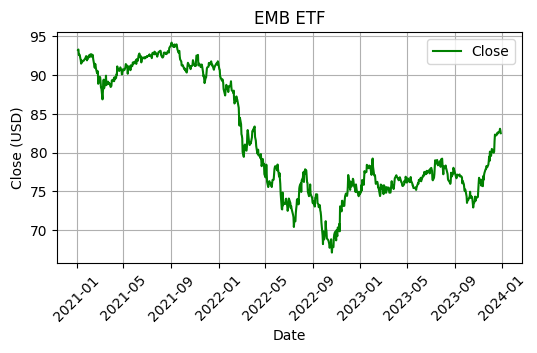

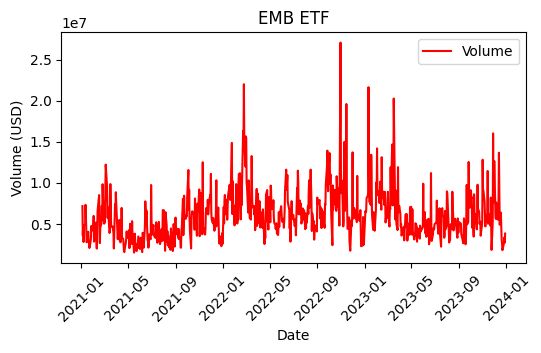

In [17]:
def basic_plots(colonna, colore, dimensioni, griglia=True):
  plt.figure(figsize=dimensioni)
  plt.plot(df_emb.index,colonna,label=colonna.name, color=colore)
  plt.xlabel("Date")
  plt.ylabel(f"{colonna.name} (USD)")
  plt.title("EMB ETF")
  plt.legend()
  plt.xticks(rotation=45)
  plt.grid(griglia)
  plt.show()

basic_plots(colonna=df_emb.Close, colore="green", dimensioni=(6, 3))
basic_plots(df_emb.Volume, "red", (6, 3), griglia=False)

A preliminary analysis of trading volume data reveals two significant spikes in activity (second graph), each associated with distinct market conditions.

- The first spike coincides with a sharp decline in prices during the first quarter of 2022. This period marked the onset of geopolitical instability, specifically the escalation of the Russia-Ukraine conflict in February 2022. The surge in trade volume likely reflects large-scale sell-offs, as investors reduced their exposure to emerging market bonds in response to heightened uncertainty and increased risk aversion.

- The second, more pronounced spike occurred in the fourth quarter of 2022. When examining both graphs together, it becomes evident that this surge in trading volume was driven by a market rally. Higher yields (due to central banks tighter monetary policies) on emerging market bonds attracted investors, reversing the prior trend and leading to significant buying activity.


### Time series model fitting

#### Tests:

Now, I shall calculate Log Returns as it is mostly done in practice for financial time-series; they offer a list of advantages, among them one could include for example that they have a symmetric distribution and also for they additivity (simple sum) over the long run.

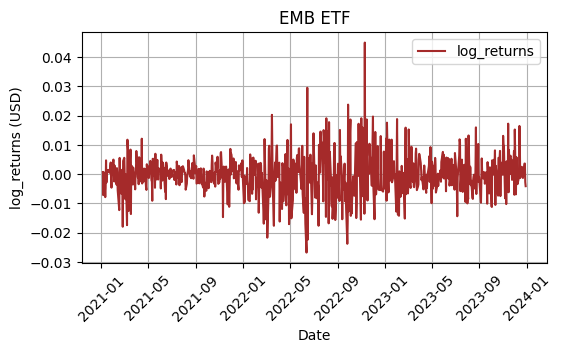

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
def log_returns(data):
  return np.log(data / data.shift(1))

df_emb["log_returns"] = log_returns(df_emb["Close"])
df_emb.dropna(inplace=True)
basic_plots(df_emb.log_returns, "brown", (6, 3))
df_emb.describe()

From the plot of log_returns, one could immediately observe clusters of higher intensity during 2022.

To assess stationarity in my time series data, I will apply the Augmented Dickey-Fuller (ADF) test. This statistical test helps detect the presence of unit roots, indicating whether the series exhibits non-stationarity. If a unit root is found, a transformation—such as first differencing—may be necessary to make the data stationary.\
The null hypothesis in the ADF test states that the time series has a unit root (i.e., it is non-stationary), while the alternative hypothesis suggests the series is stationary.

In [19]:
adf = adfuller(df_emb["log_returns"])
print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

ADF Statistic: -21.15247115930363
p-value: 0.0


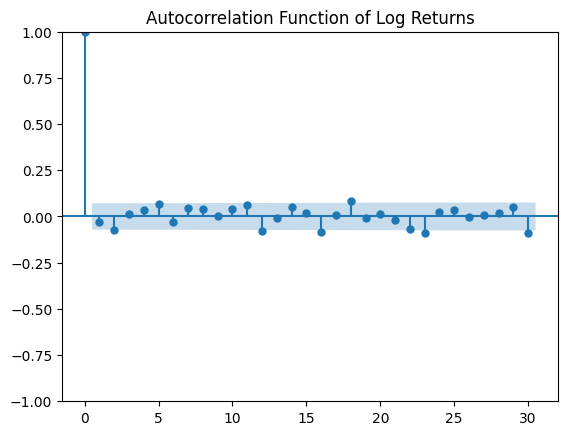

In [20]:
def acf_plotting(data, power=1, pacf=False):
  if not pacf:
    plot_acf(data.dropna()**power, lags=30)
    if power == 2:
      plt.title("Autocorrelation Function of Squared Log Returns")
    else:
      plt.title("Autocorrelation Function of Log Returns")
  else:
    plot_pacf(data.dropna()**power, lags=30)
    if power == 2:
      plt.title("Partial Autocorrelation Function of Squared Log Returns")
    else:
      plt.title("Partial Autocorrelation Function of Log Returns")
  plt.show()

acf_plotting(df_emb["log_returns"])

Both from the ADF test-statistic and p-value and from the Autocorrelation Graph it is clearly evident that the series can be assumed as stationary.\
In particular, p-values near zero represent strong evidence against the null-hypothesis, whilst an ACF graph where almost no spike are relevant at lower lags over the significance level, shows that log-returns do not exhibit strong autocorrelation.\
Since my primary focus is volatility modeling—and stationarity is established—there is no need to introduce an ARIMA model to capture the mean process.

A different measure that we can explore is the ACF graph of squared log-returns; in that case the analysis is focused on autocorrelation in **volatility** (main focus of this analysis):

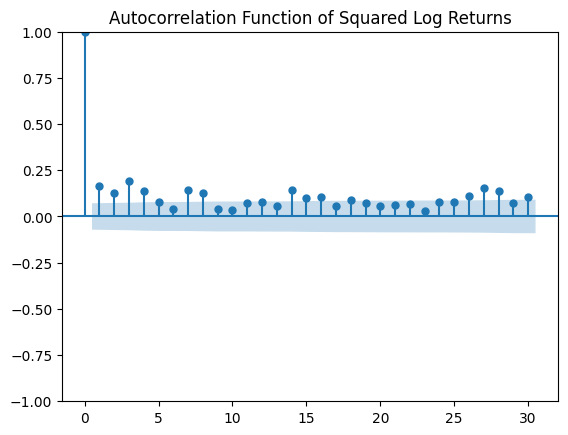

In [21]:
acf_plotting(df_emb["log_returns"], power=2)

In the second plot, we are visualising autocorrelation in volatility, investigating whether today's market turbulence persist over time.\
Here one can observe that spikes persist over time, confirming volatility clustering in the series and justifying the use of GARCH models.\
Moreover, I will try to fit higher order GARCH further in the analysis, given that the effect is above signficance level at least for the first 3/4 lags (we do not consider too-far lags in the plot).\
More formally, let me perform a ARCH-LM test, in this test under the null-hypothesis there is no ARCH (Autoregressive Conditional Heteroskedasticity) in the residuals:

In [22]:
arch_test = het_arch(df_emb["log_returns"].dropna())
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")

LM Statistic: 63.85984564161823
P-value: 6.693584584465453e-10


A p-value near zero strongly point against the null-hypothesis, therefore we can suggest that the errors exhibit ARCH effect, indicating time-varying variance (ample/small movements will tend to follow previous ample/small movements).\
The presence of ARCH effects confirms that volatility tends to cluster over time, aligning with well-known characteristics of financial markets.

Let me try and fit a GARCH model then.

#### **GARCH MODELS**

##### GARCH(1,1)

Starting from the most basic GARCH(1,1) process on log-returns.\
The function garch_fun is defined for replicability.

In [23]:
def garch_fun(my_data,my_p,my_q,vol_model,distribuzione="normal",force_omega=False):
  garch_model = arch_model(my_data.dropna(), vol=vol_model, p=my_p, q=my_q, dist=distribuzione)
  garch_fit = garch_model.fit(disp="off")
  if force_omega:
    garch_fit.params["omega"] = 0
  return garch_fit

garch_1_1 = garch_fun(my_data=df_emb["log_returns"]*100,my_p=1,my_q=1,vol_model="Garch") # Log returns rescaled
print(f"GARCH(1,1):{garch_1_1.summary()}")

GARCH(1,1):                     Constant Mean - GARCH Model Results                      
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -716.238
Distribution:                  Normal   AIC:                           1440.48
Method:            Maximum Likelihood   BIC:                           1458.97
                                        No. Observations:                  752
Date:                Mon, Jun 09 2025   Df Residuals:                      751
Time:                        21:26:57   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.5759e-03  1.871e-02     -0.

- Mean Model analysis:
  - R-squared: not of interest given that GARCH do not model returns themselves and returns are tipically modelled as a white noise;
  - **mu** is statistically insignificant given its high p-value (and moreover the estimated coef would also be zero); the mean return does not significantly deviate from zero, so log-returns tend to be mean-reverting and fluctutate around zero.
- Volatility Model analysis:
  - omega ($\omega$): the baseline variance represents the long-run volatility level; high p-value indicates statistic insignificance and thus suggesting that volatility could be primarily driven by past shocks rather than a constant baseline variance;
  - alpha[1] ($\alpha$): the short-term volatility coefficient captures the impact of recent shocks on volatility; the estimated coefficient of 0.0884 is highly significant (very low p-value), indicates that market movements have a moderate effect on short-term volatility;
  - beta[1] ($\beta$): this measures how long volatility persists over time; the estimated coefficient of 0.9017 is extremely significant and volatility is thus highly persistent - large price movements tend to influence future volatility for an extended period.

  Moreover,
  $$
  \alpha + \beta \approx 1 \\ \alpha + \beta < 1
  $$

 This is a very important point, the sum of the coefficients $\alpha$ and $\beta$ is very close and inferior to one:\
 - the latter insures that volatility does not explode over time,
 - The near-unit root behavior suggests volatility is highly persistent but still mean-reverting, albeit at a very slow rate;
 In this case, IGARCH (Integrated GARCH) models could also be a right fit for the data, since they remove $\omega$ from the equation, enforcing the unit root condition.\
 Given that in the estimated coefficient of the model $\omega$ resulted as statistically insignificant, an IGARCH(1,1) could definetely be appropriate.

Here follows the IGARCH(1,1) fitting:

###### I-GARCH(1,1)

In [24]:
# Fitting the IGARCH(1,1) with omega forced to zero:
igarch_1_1 = garch_fun(my_data=df_emb["log_returns"]*100,my_p=1,my_q=1,vol_model="Garch",force_omega=True)
print(f"IGARCH(1,1): {igarch_1_1.summary()}")

IGARCH(1,1):                      Constant Mean - GARCH Model Results                      
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -716.238
Distribution:                  Normal   AIC:                           1440.48
Method:            Maximum Likelihood   BIC:                           1458.97
                                        No. Observations:                  752
Date:                Mon, Jun 09 2025   Df Residuals:                      751
Time:                        21:26:57   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.5759e-03  2.531e-02     -

The results are the same, except this time omega has been forced to zero.\
The sum of $\alpha$ and $\beta$ is 0.9977 but volatility is assumed to not revert to a baseline.\
Given that the Log-Likelihood, AIC and BIC are exactly the same, the two models are assumed to be equal.\
However, given that the persistance component does not sum up to **EXACTLY** one, let us stick with GARCH(1,1), just for simplicity.

Let me visualise the conditional volatility modelled here.

###### GARCH(1,1) (again)

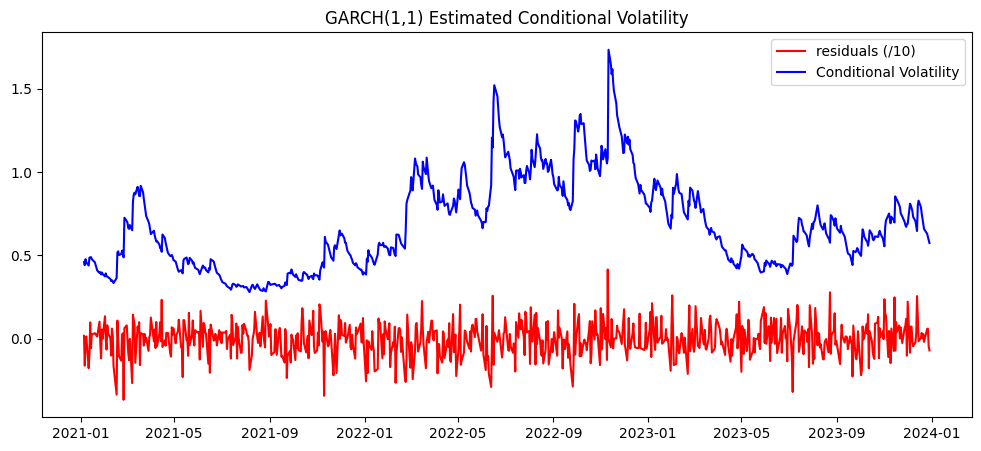

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(garch_1_1.std_resid/10, label="residuals (/10)", color="red")
plt.plot(garch_1_1.conditional_volatility, label="Conditional Volatility", color="blue")
plt.title("GARCH(1,1) Estimated Conditional Volatility")
plt.legend()
plt.show()

- **Volatility clusters are evident**, indicating that the GARCH model correctly identifies periods of increased market fluctuations.
- **Persistence is visible**, meaning volatility remains elevated for extended durations before gradually declining.
- **No extreme spikes**, suggesting the model does not produce unrealistic volatility jumps, ensuring stability in its predictions.
- Mean in the residuals is zero.

Now, in order to assess the adequacy of the model, let me check the pattern of standardised residuals.\
In particular, they should resemble white nois with no significant autocorrelation.  

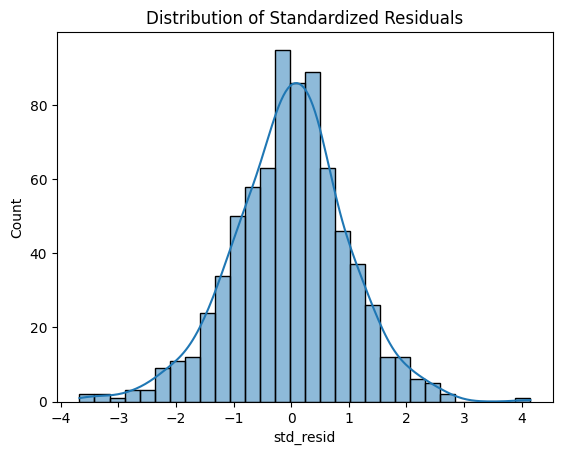

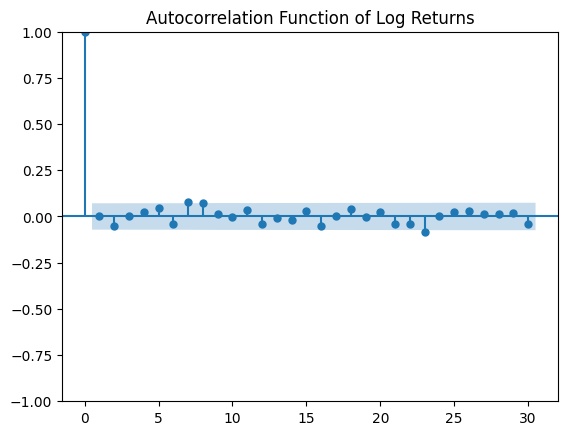

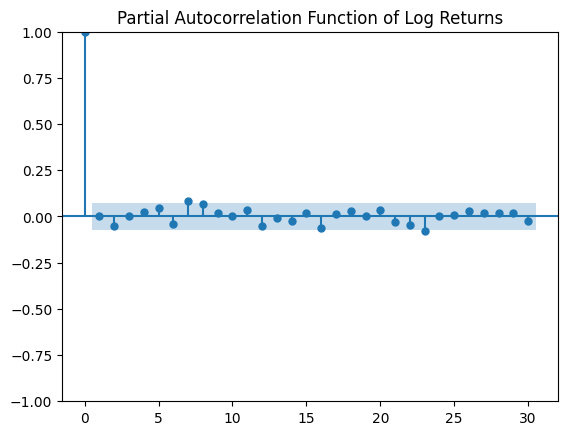

 
Shapiro-Wilk Test Statistic: 0.9928, P-value: 0.0011
 
Ljung-Box Test:
      lb_stat  lb_pvalue
1    0.009794   0.921166
2    1.968431   0.373732
3    1.985679   0.575384
4    2.474126   0.649275
5    3.943555   0.557571
6    5.265013   0.510300
7    9.731703   0.204294
8   13.899540   0.084422
9   14.021239   0.121572
10  14.022273   0.171978


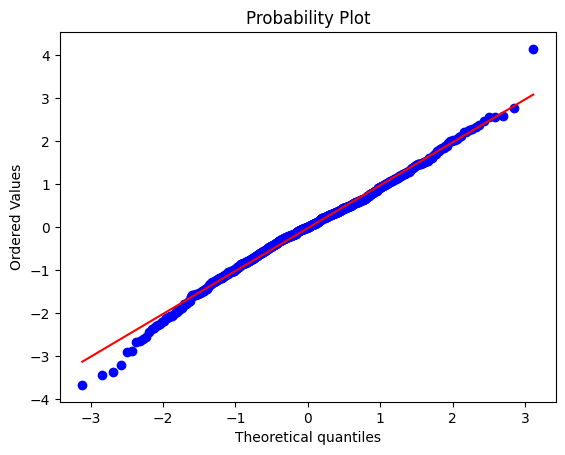

In [26]:
def residual_analysis(my_model,qq="normal"):
  std_residuals = my_model.std_resid
  # Residuals plot
  sns.histplot(std_residuals,kde=True)
  plt.title("Distribution of Standardized Residuals")
  plt.show()
  # ACF and PACF
  acf_plotting(std_residuals, power=1)
  acf_plotting(std_residuals, power=1, pacf=True)
  # QQ plot
  if qq == "normal":
    stats.probplot(std_residuals, dist="norm", plot=plt)
  else:
    stats.probplot(std_residuals, dist=stats.t(df=my_model.params["nu"]), plot=plt)
  # Normality test
  stat, p = shapiro(std_residuals)
  print(" ")
  print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, P-value: {p:.4f}")
  # Ljung-Box test
  print(" ")
  print("Ljung-Box Test:")
  print(f"{acorr_ljungbox(std_residuals, lags=10)}")



residual_analysis(garch_1_1)

Residual analysis:
- First of all, ACF and PACF plots show no significant spikes and no visible structure, this is an indication that the GARCH model correclty capture volatility dynamics in the time-series (therefore, no ARMA component required, log-returns behave like a stationary process).\
This is confirmed by the Ljung-Box test, since we fail to reject the null-hypothesis at all lags we have no sign of significant autocorrelation.
- Moving to residuals distribution, from the first plot one could notice that the distribution is not far from a Normal Distribution, however its evident heavier tails result in a Shapiro test statistic that acts in favour of the alternative hypothesis: residuals are not normally distributed.\
Also from the Q-Q plot we observe tail deviations.\
In this case, the presence of fat tails suggests that a **GARCH-t** may be more appropriate than assuming normal residuals.

##### GARCH-t(1,1)

In [27]:
garch_t_1_1 = garch_fun(my_data=df_emb["log_returns"]*100,my_p=1,my_q=1,vol_model="Garch",distribuzione="t")
print(f"GARCH-t(1,1): {garch_t_1_1.summary()}")

GARCH-t(1,1):                         Constant Mean - GARCH Model Results                         
Dep. Variable:                  log_returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -709.023
Distribution:      Standardized Student's t   AIC:                           1428.05
Method:                  Maximum Likelihood   BIC:                           1451.16
                                              No. Observations:                  752
Date:                      Mon, Jun 09 2025   Df Residuals:                      751
Time:                              21:26:59   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------

The mean model is practically the same.
Parameters $\alpha$ and $\beta$ slightly differ but the Volatility Model is very similar (also $\omega$ is insignificant).

**Distribution**: the coefficient \$nu$ (degrees of freedom) is highly significant, confirming the presence of fat tails.\
This results suggests that extreme price movements are more frequent than a standard normal distribution would predict, reinforcing the choice of a **GARCH-t**.

Moreover, if we look at the statistics of fitting we observe that:

- Log-Likelihood: higher in the GARCH-t (better model fit);
- Lower AIC/BIC: improved efficiency in balancing complexity vs accuracy.

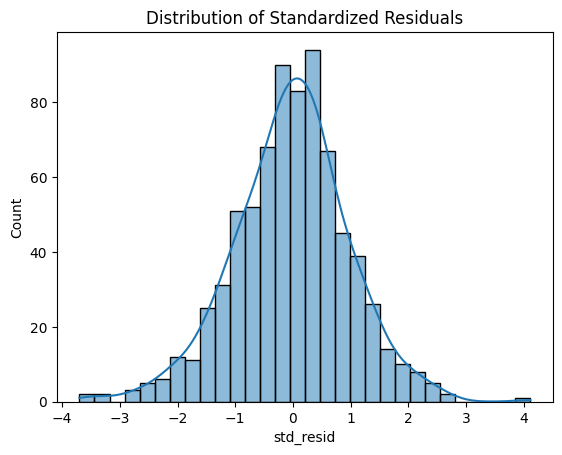

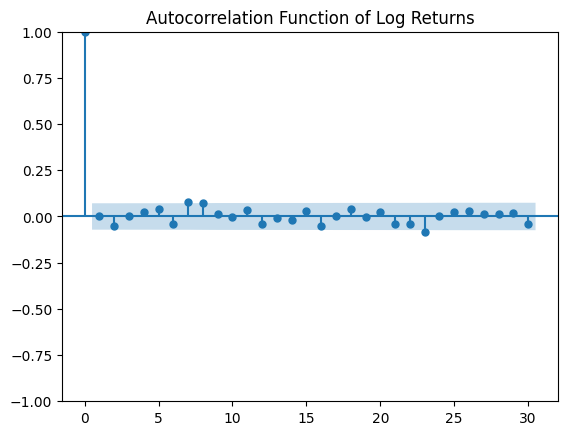

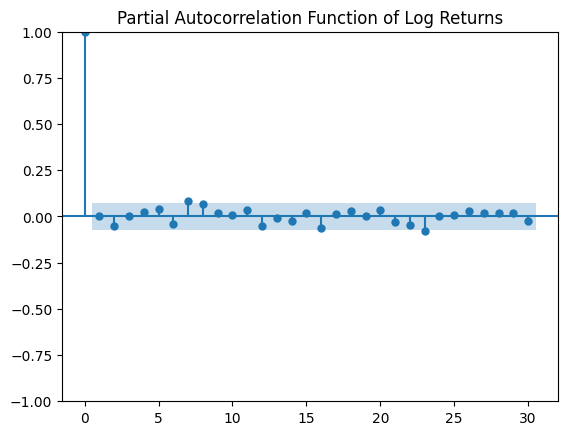

 
Shapiro-Wilk Test Statistic: 0.9927, P-value: 0.0009
 
Ljung-Box Test:
      lb_stat  lb_pvalue
1    0.009973   0.920451
2    2.001784   0.367551
3    2.015652   0.569164
4    2.530378   0.639204
5    3.880001   0.566819
6    5.187562   0.519992
7    9.767104   0.202160
8   13.963943   0.082710
9   14.092812   0.119062
10  14.093753   0.168758


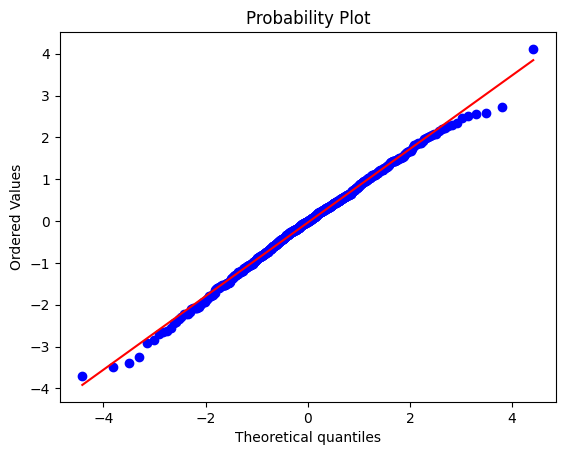

In [28]:
residual_analysis(garch_t_1_1,qq="t")

The Q-Q plot demonstrates slightly-improved tail alignment compared to the previous model, with residuals now extending to an absolute value of 4, instead of 3, before deviating a little bit. This indicates that the Student’s t-distribution better accommodates extreme values, suggesting an improved fit for volatility clustering and heavy-tailed behavior.

Now that I have found a more suitable fitting for modelling the time series and the residuals, let me try different configurations for the model (higher levels of p and q), given that we encountered in the plot of the ACF of the squared residuals significant spike further in time.

##### GARCH-t(p,q)

Let me try different configuration of model complexity, using the previously defined **garch_fun** function in a for loop:

In [29]:
conf = [[1,1],[1,2],[2,1],[2,2],[1,3],[3,1],[2,3],[3,2],[3,3]]

for i in conf:
  garch_t_p_q = garch_fun(my_data=df_emb["log_returns"]*100,my_p=i[0],my_q=i[1],vol_model="Garch",distribuzione="t")
  print(f"GARCH-t[{i}]: Log-Lik:{garch_t_p_q.loglikelihood}, AIC:{garch_t_p_q.aic}, BIC:{garch_t_p_q.bic}")

GARCH-t[[1, 1]]: Log-Lik:-709.0232396032663, AIC:1428.0464792065327, BIC:1451.160160826282
GARCH-t[[1, 2]]: Log-Lik:-707.1850379925695, AIC:1426.370075985139, BIC:1454.106493928838
GARCH-t[[2, 1]]: Log-Lik:-709.0232395067397, AIC:1430.0464790134795, BIC:1457.7828969571785
GARCH-t[[2, 2]]: Log-Lik:-707.1850382591701, AIC:1428.3700765183403, BIC:1460.729230785989
GARCH-t[[1, 3]]: Log-Lik:-706.2288077170767, AIC:1426.4576154341535, BIC:1458.8167697018023
GARCH-t[[3, 1]]: Log-Lik:-709.0232398972764, AIC:1432.0464797945529, BIC:1464.4056340622017
GARCH-t[[2, 3]]: Log-Lik:-706.2288074306946, AIC:1428.4576148613892, BIC:1465.439505452988
GARCH-t[[3, 2]]: Log-Lik:-707.18503802652, AIC:1430.37007605304, BIC:1467.3519666446389
GARCH-t[[3, 3]]: Log-Lik:-705.7183262097699, AIC:1429.4366524195398, BIC:1471.0412793350883


In the choice of the mode, lower AIC/BIC values indicate a better trade-off between model complexity and fit. In this case:

- the lowest AIC is found for GARCH-t(1,2);
- the lowest BIC is found for GARCH-t(1,1) → notice that BIC penalises more model complexity.

So, even if higher values of Log-Likelihood might be obtain for higher configurations of the model, we should consider the importance of complexity.\
In this case, given that the BIC for the GARCH-t(1,2) is only slighty higher than GARCH-t(1,1), the AIC is slower and the Log-Likelihood is higher, I shall proced with a **GARCH-t(1,2)** as final choice.

##### GARCH-t(1,2)

1. **Improved Tail Modeling:** The Student’s t-distribution better captures extreme movements in financial markets compared to the normal distribution.
2. **Volatility Persistence:** The squared residual autocorrelation suggests longer-term dependence, supporting the choice of a higher-order model.
3. **Balanced Complexity:** While increasing p and q further improves log-likelihood, the gains are marginal compared to the increased model complexity.
4. **Lower AIC:** GARCH-t(1,2) achieves the lowest AIC, ensuring a strong fit without excessive overparameterization.

The parameters of the model are:

In [30]:
garch_t_1_2 = garch_fun(my_data=df_emb["log_returns"]*100,my_p=1,my_q=2,vol_model="Garch",distribuzione="t")
print(f"GARCH-t(1,2): {garch_t_1_2.summary()}")

GARCH-t(1,2):                         Constant Mean - GARCH Model Results                         
Dep. Variable:                  log_returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -707.185
Distribution:      Standardized Student's t   AIC:                           1426.37
Method:                  Maximum Likelihood   BIC:                           1454.11
                                              No. Observations:                  752
Date:                      Mon, Jun 09 2025   Df Residuals:                      751
Time:                              21:27:00   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------

- Volatility clustering is well captured, given that $\alpha[1]$ is highly significant.
- Baseline variance is again not statistically significant.
- $\beta[1]$ appears to be not statistically significant while $\beta[2]$ is highly significant, meaning that volatility persistance is primarily driven by the second lag rather than the first.
- $\nu$ of the t-Student's distribution is highly significant.

###### Forecasting with GARCH-t(1,2)

Since I selected the GARCH-t(1,2) as best representation of volatility in my series, now I will evaluate its forecasting power on a 30 days horizon, and then compare the forecasts with the actual realization of market data.\
Using the model, I will generate out-of-sample forecasts on conditional volatility. In practice, such framework is used in portfolio allocation and risk mitigation strategies, as well as trading decisions.

First, let me define a set of function that I will use in this part of code. The functions are defined for replicability and are useful in retrieving forecast for different time horizons and plotting results.

In [31]:
def metrics(forecast, realised):
  print(f"Mean Absolute Error (MAE): {np.mean(np.abs(forecast - realised)):.4f}")
  print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean((forecast - realised) ** 2)):.4f}")

In [32]:
# Forecasting with confidence intervals:
def forecasting_with_ci(my_model, start_date="2024-01-02", forecast_hor=30, trad_d=1):
    vol_forecast = my_model.forecast(horizon=forecast_hor, reindex=False)
    var = vol_forecast.variance.iloc[-1]
    sigma = np.sqrt(var) * np.sqrt(trad_d)

    upper = sigma * 1.05
    lower = sigma * 0.95

    dates = pd.date_range(start=pd.Timestamp(start_date), periods=forecast_hor, freq="D").normalize()
    sigma.index = dates
    upper.index = dates
    lower.index = dates

    return sigma, upper, lower

In [33]:
def vola_plot(data, upper=None, lower=None, hist=None, model="GARCH-t(1,2)", label="forecast", start_date="2024-01-02", roll=30, frequency="D",fig_size=(8,6)):
    # interval
    forecast_start_date = pd.Timestamp(start_date)
    correct_dates = pd.date_range(start=forecast_start_date, periods=roll, freq=frequency)
    data.index = correct_dates
    if upper is not None and lower is not None:
        upper.index = correct_dates
        lower.index = correct_dates

    # convert dates
    x_dates = mdates.date2num(data.index)

    plt.figure(figsize=fig_size)
    plt.plot(x_dates, data, label=model + " forecast", color="blue")

    # c.i.
    if upper is not None and lower is not None:
        plt.fill_between(x_dates, lower, upper, color='blue', alpha=0.2, label="95% Confidence Interval")

    # if I want to add a comparison with realised volatility, I can specify the data:
    if label == "compare" and hist is not None:
        hist = hist.reindex(correct_dates).dropna()
        plt.plot(mdates.date2num(hist.index), hist, label="Realised Volatility", color="orange")

    plt.title(model + " Forecast on conditional volatility" + (" VS realised volatility" if label == "compare" else ""))
    plt.xlabel("Date")
    plt.ylabel("Volatility (Standard Deviation)")
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
# realised volatility:
def realised_vola(data, w=30, trad_d=1):
  return data.rolling(window=w).std() * np.sqrt(trad_d)

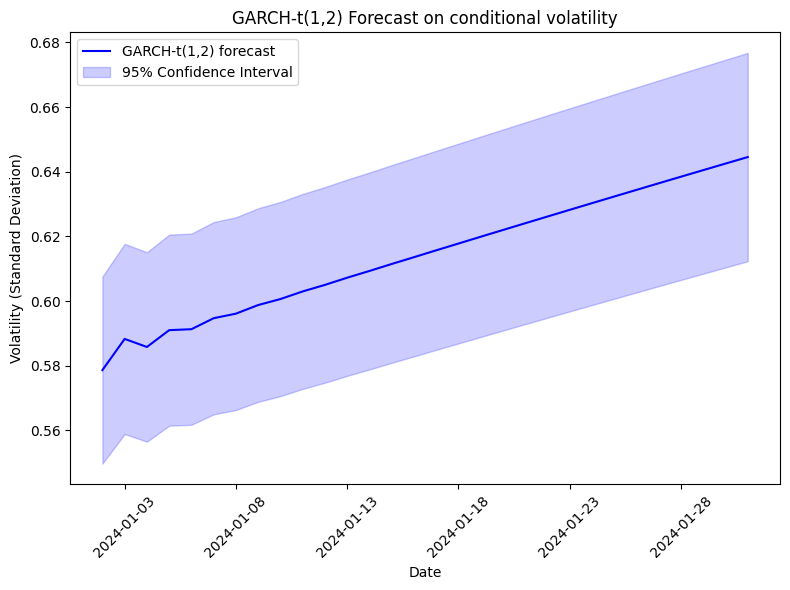

In [35]:
future_vola, upper_ci, lower_ci = forecasting_with_ci(garch_t_1_2)
vola_plot(future_vola, upper=upper_ci, lower=lower_ci)

The conditional volatility forecast suggests an **increasing trend** in market uncertainty over the next 30 days, indicating potential market instability. This aligns with volatility clustering behavior, where periods of high volatility tend to persist over time.\
Moreover, the model does not predict suddend shocks, suggesting a steady rise.

To evalute the forecasting power of the model, I will compare the forecasted conditional volatility with the actual volatility observed in the market, and plotting the two together.

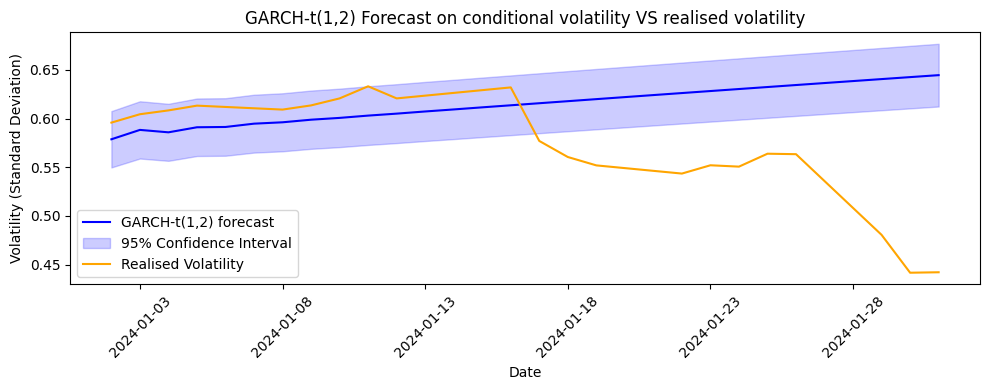

In [36]:
# Download data with the function that I have built in the beginning:
df_emb_ahead = download_data(ticker=yf.Ticker("EMB"), start_date="2023-11-15", end_date="2024-04-01", interval="1d")
# log returns with my function:
df_emb_ahead["log_returns"] = log_returns(df_emb_ahead["Close"])
df_emb_ahead.dropna(inplace=True)  # Rimuove eventuali valori NaN

# realised vola with the function described above:
realised = realised_vola(df_emb_ahead["log_returns"]*100)
vola_plot(future_vola, upper=upper_ci, lower=lower_ci, hist=realised, label="compare", fig_size=(10,4))

The GARCH-t(1,2) model provides a smooth and slightly upward-sloping forecast of conditional volatility for the 30-day horizon starting from January 2, 2024. The forecasted values remain within a narrow confidence interval, reflecting the model's stability and its assumption of volatility clustering.\
Moreover, one can observe that after the first few steps the model converges to its long run unconditional variance.

Looking at the plot, at the beginning of the forecast period, the model's predictions align closely with the realized volatility observed in the market. However, from mid-January 2024 onwards, the realized volatility starts to decline more sharply than predicted, eventually falling below the 95% confidence interval. This deviation may indicate the presence of an unexpected structural change or a volatility regime shift that the model could not anticipate.

Overall, while the model captures general trends and provides reasonable uncertainty bounds, it tends to underreact to sudden drops in volatility. This suggests that alternative specifications (e.g., EGARCH, GJR-GARCH) or additional information might be needed to improve short-term responsiveness.

Let me focus on the short-term predictive power of the model:



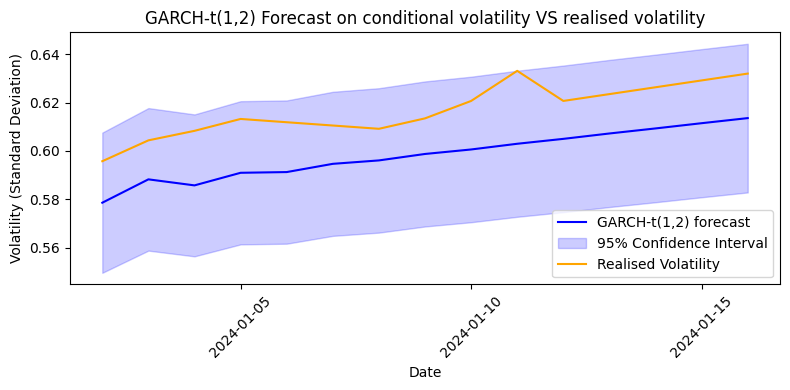

Mean Absolute Error (MAE): 0.0190
Root Mean Squared Error (RMSE): 0.0196


In [37]:
future_vola_15d, upper_15d, lower_15d = forecasting_with_ci(garch_t_1_2, forecast_hor=15)
vola_plot(future_vola_15d, upper=upper_15d, lower=lower_15d, hist=realised, label="compare", roll=15, fig_size=(8,4))

# metrics:
future_vola_15d_aligned, realised_15d_aligned = future_vola_15d.align(realised, join="inner")
metrics(future_vola_15d_aligned, realised_15d_aligned)

These results confirm the robustness of the GARCH-t(1,2) model over a 15-day forecast horizon. The absolute errors are small in magnitude, and the relative error remains below 3.1% on average. This suggests that the model captures the short-term volatility dynamics effectively, with reasonably narrow confidence intervals and strong alignment with realized volatility.

Let me now expand forecasting by moving to a rolling windows of 10 days.

###### Rolling window Forecast

In [38]:
# use a full timeseries:
df_emb_full = download_data(ticker=yf.Ticker("EMB"),start_date="2022-08-01", end_date="2025-05-28", interval="1d")
df_emb_full["log_returns"] = log_returns(df_emb_full["Close"])
df_emb_full.dropna(inplace=True)

In [39]:
def rolling_garch_forecast(returns, my_p=1, my_q=1, my_dist="t", model_vol="GARCH",
                            window_size=500, forecast_hor=1, step=1, trad_d=252,
                            start_date=None, end_date=None):
    """
    Rolling forecast for GARCH/EGARCH models.
    """
    if start_date:
        returns = returns[returns.index >= pd.to_datetime(start_date)]
    if end_date:
        returns = returns[returns.index <= pd.to_datetime(end_date)]

    forecast_list = []
    realised_list = []
    date_list = []

    for i in range(window_size, len(returns) - forecast_hor, step):
        train = returns.iloc[i - window_size:i]
        test_window = returns.iloc[i:i + forecast_hor]

        model = arch_model(train, p=my_p, q=my_q, vol=model_vol, dist=my_dist)
        fit = model.fit(disp="off")

        forecast = fit.forecast(horizon=forecast_hor, reindex=False)
        sigma_f = np.sqrt(forecast.variance.iloc[-1]) * np.sqrt(trad_d)

        # For example fot EGARCH model the horizon HAS TO BE 1
        if forecast_hor == 1:
            future_window = returns.iloc[i + forecast_hor : i + forecast_hor + 3]  # we cannot compute standard deviation on one value, so we use a subset in a neighborhood of points
            if len(future_window) >= 2:
                realised = future_window.std() * np.sqrt(trad_d)
            else:
                realised = np.nan
        else:
            realised = test_window.rolling(window=forecast_hor).std().iloc[-1] * np.sqrt(trad_d)

        forecast_list.append(sigma_f.mean())
        realised_list.append(realised)
        date_list.append(test_window.index[-1])

    return pd.DataFrame({
        "date": date_list,
        "forecast_vol": forecast_list,
        "realised_vol": realised_list
    }).set_index("date")

In [40]:
def plot_rolling_result(rolling_result, model_name="GARCH-t(1,2)",fig_size=(8,4), roll=10):
    plt.figure(figsize=fig_size)
    plt.plot(rolling_result.index, rolling_result["forecast_vol"], label="Forecast Volatility", color="blue")
    plt.plot(rolling_result.index, rolling_result["realised_vol"], label="Realised Volatility", color="orange")
    plt.fill_between(rolling_result.index,rolling_result["forecast_vol"],rolling_result["realised_vol"],color='grey', alpha=0.1)
    plt.title(f"{model_name} - Rolling Forecast vs Realised Volatility ({roll} days rolling)")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [41]:
rolling_result = rolling_garch_forecast(returns = df_emb_full["log_returns"]*100, window_size=500, forecast_hor=10)

In [42]:
rolling_result.describe()

,forecast_vol,realised_vol
count,197.000000,197.000000
mean,7.303571,7.008033
std,0.852153,3.705044
min,5.899814,2.771388
25%,6.702259,4.923270
50%,7.205113,6.003822
75%,7.700079,7.856326
max,11.788530,21.708429


In [43]:
metrics(rolling_result["forecast_vol"],rolling_result["realised_vol"])

Mean Absolute Error (MAE): 2.4698
Root Mean Squared Error (RMSE): 3.8234


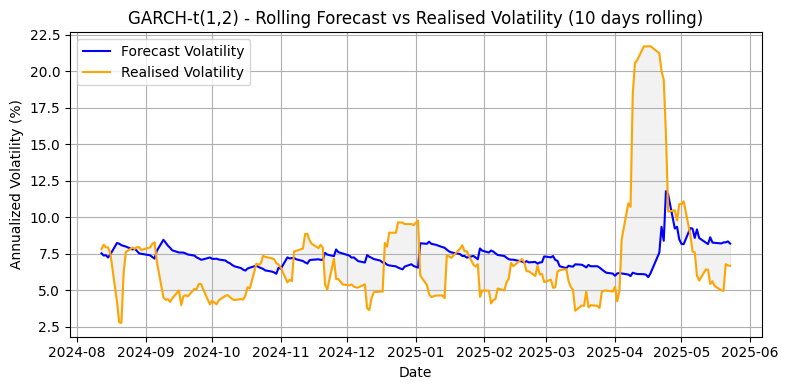

In [44]:
plot_rolling_result(rolling_result)

The GARCH-t(1,2) model provides a stable forecast of volatility over time, but it shows clear limitations when facing sudden jumps or drops in realized volatility.

While the forecast performs well in stable periods, it tends to underreact to volatility shocks and overestimates in calm periods. This suggests that more flexible or asymmetric volatility models (e.g., EGARCH) may offer improved responsiveness to dynamic market conditions.

In [45]:
# Rolling EGARCH rolling 1 day
rolling2 = rolling_garch_forecast(returns = df_emb_full["log_returns"] * 100,my_p = 1,my_q = 1,my_dist = "t",model_vol = "EGARCH",
                                  window_size = 500,forecast_hor = 1,start_date = "2023-01-01")
rolling2 = rolling2.dropna()

_Note that:_ the starting date had to be changed for stability purposes. For 250 days for example I was receiving warning messages since the model was not able to converge to an optimal solution.

In [46]:
print("NaN nel forecast:", rolling2["forecast_vol"].isna().sum())
print("NaN nel realised:", rolling2["realised_vol"].isna().sum())

NaN nel forecast: 0
NaN nel realised: 0


In [47]:
metrics(rolling2["forecast_vol"], rolling2["realised_vol"])

Mean Absolute Error (MAE): 3.8680
Root Mean Squared Error (RMSE): 6.2407


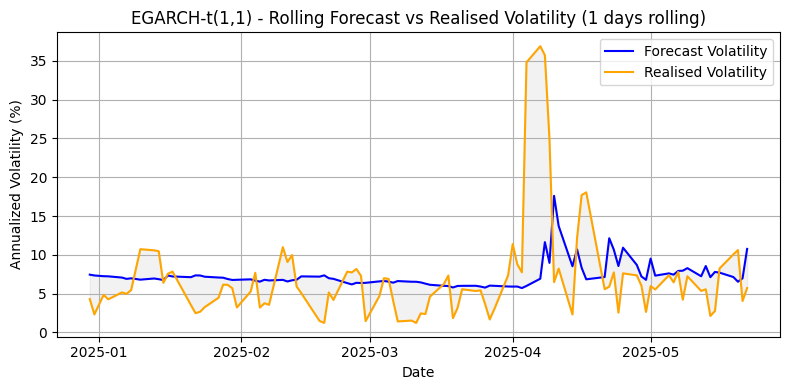

In [48]:
plot_rolling_result(rolling2, model_name="EGARCH-t(1,1)", roll=1)

The EGARCH model, as implemented in the `arch` Python package, supports only one-step-ahead forecasts analytically. Attempting longer horizons (e.g., 10-day forecasts) is not supported and would require Monte Carlo simulation, which will not be explored in this analysis. This results in different forecast horizons for the two models, limiting strict comparability.

Despite its ability to capture asymmetries and leverage effects, the EGARCH(1,1) model performed worse than the simpler GARCH(1,2) in this context. The GARCH model yielded lower MAE and RMSE values, indicating better alignment with realized market volatility over a 10-day horizon.

Moreover, one can appreciate visually sudden changes in volatility with this model.


Let me try to compare the two models on the same horizon (1 day).

In [49]:
rolling_result3 = rolling_garch_forecast(returns = df_emb_full["log_returns"]*100, window_size=500, forecast_hor=1)
print("GARCH-t(1,2), horizon = 1 day rolling forecast:")
metrics(rolling_result3["forecast_vol"],rolling_result3["realised_vol"])
rolling_result4 = rolling_garch_forecast(returns = df_emb_full["log_returns"]*100, window_size=500, forecast_hor=5)
print("GARCH-t(1,2), horizon = 5 days rolling forecast:")
metrics(rolling_result4["forecast_vol"],rolling_result4["realised_vol"])

GARCH-t(1,2), horizon = 1 day rolling forecast:
Mean Absolute Error (MAE): 3.7205
Root Mean Squared Error (RMSE): 5.2604
GARCH-t(1,2), horizon = 5 days rolling forecast:
Mean Absolute Error (MAE): 3.0894
Root Mean Squared Error (RMSE): 4.3905


###### Forecasting results:

This table compares the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) of different volatility models, both with and without rolling windows. Metrics are reported in both annualized and daily scales for clarity.

| Model             | Horizon | Rolling | MAE (Annualized) | RMSE (Annualized) | MAE (Daily) | RMSE (Daily) |
|-------------------|---------|---------|------------------|--------------------|-------------|---------------|
| GARCH(1,2)        | 10d     | Yes     | 2.4698           | 3.8234             | 0.1556      | 0.2409        |
| GARCH-t(1,2)      | 1d      | Yes     | 3.7205           | 5.2604             | 0.2344      | 0.3314        |
| GARCH-t(1,2)      | 5d      | Yes     | 3.0894           | 4.3905             | 0.1946      | 0.2766        |
| EGARCH(1,1)       | 1d      | Yes     | 3.8679           | 6.2405             | 0.2437      | 0.3931        |
| GARCH-t(1,2)      | 15d     | **No**  | —                | —                  | **0.0190**  | **0.0196**    |

---

- The **non-rolling GARCH-t(1,2)** forecast over 15 days produced the lowest daily error metrics, but this comes from fitting the model once and forecasting forward, for a particular and limited time window.
- Rolling models retrain at each step, which reflects real-world use but introduces more variability.
- The best-performing **rolling** model remains **GARCH(1,2)** with a 10-day horizon:
  -  The **GARCH(1,2)** model with a 10-day forecast horizon achieved the lowest MAE and RMSE, indicating strong alignment with realised volatility.
  - The GARCH-t(1,2) model showed improved performance over EGARCH(1,1) at shorter horizons (1 and 5 days), suggesting better handling of heavy-tailed distributions.
  - EGARCH(1,1), while theoretically more flexible due to its ability to model asymmetries in volatility, **did not outperform** the simpler GARCH-based alternatives in this case.


##### GARCH Models: Conclusions

This analysis aimed to evaluate and compare the forecasting performance of different GARCH-type models on the EMB ETF, using both rolling and non-rolling forecast frameworks.

The models considered include GARCH(1,2), GARCH-t(1,2), and EGARCH(1,1), with various forecast horizons ranging from 1 to 10 days. Forecasting accuracy was assessed by comparing model-generated conditional volatility with realised volatility, using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) as primary evaluation metrics.

The best-performing model in the rolling forecast context was the GARCH-t(1,2) with a 10-day horizon. It consistently achieved the lowest MAE and RMSE, indicating strong alignment with observed volatility over time and remarking its capacity to handle heavy-tailed return distributions.\
In contrast, EGARCH(1,1), despite its theoretical advantage in modelling asymmetries, did not outperform simpler alternatives in this dataset.

Interestingly, the non-rolling GARCH-t(1,2) model over a fixed 15-day horizon exhibited the lowest error metrics overall. However, this result should be interpreted with caution, as it reflects a one-shot forecast without daily retraining, making it less representative of a real-time forecasting setup.

Overall, rolling forecasts better reflect practical implementation scenarios where models are continuously updated with new data. Despite their increased computational cost and variability, they offer a more robust basis for applications such as dynamic risk management or portfolio allocation.

Future work could include testing additional specifications such as GJR-GARCH or component GARCH, exploring alternative return distributions, or extending the framework to multivariate settings.


#### Correlation analysis with Market indeces

To complement the univariate volatility models, I examined the dynamic relationship between EMB log-returns and a series of market indeces considered relevant:

- VIX: a widely used proxy for global investor fear and risk aversion.
- TNX: CBOE Interest Rate 10 Year T No
- DX-Y.NYB: US Dollar Index (FX Pressure)
- SPY: US Equity Index (Risk Sentiment)
- HYG: High-Yield Bonds
- LQD: Investment-Grade Bonds
- GLD: Gold (Safe Haven Asset)

In [84]:
# Here I define a pipeline for each index
def index_comp(name_index):

  idx_raw = yf.download(name_index, start="2021-01-01", end="2024-01-01")

  idx = idx_raw.copy()
  idx.columns = idx.columns.get_level_values(0)

  idx = idx[["Close"]].rename(columns={"Close": name_index})

  idx.index = idx.index.tz_localize(None).normalize()
  df_emb_idx = df_emb[["log_returns"]].copy()

  # Common dates
  df_merged = df_emb_idx.join(idx, how="inner")

  # plot

  rolling_corr = df_merged["log_returns"].rolling(window=30).corr(df_merged[name_index])

  plt.figure(figsize=(10, 4))
  plt.plot(rolling_corr.index, rolling_corr, color="purple", label="30d Rolling Correlation")
  plt.axhline(0, linestyle="--", color="black", alpha=0.5)
  plt.title(f"30-Day Rolling Correlation between EMB Log Returns and {name_index}")
  plt.xlabel("Date")
  plt.ylabel("Correlation")
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # overall corr
  static_corr = df_merged["log_returns"].corr(df_merged[name_index])
  print(f"Overall correlation: {static_corr:.4f}")

[*********************100%***********************]  1 of 1 completed


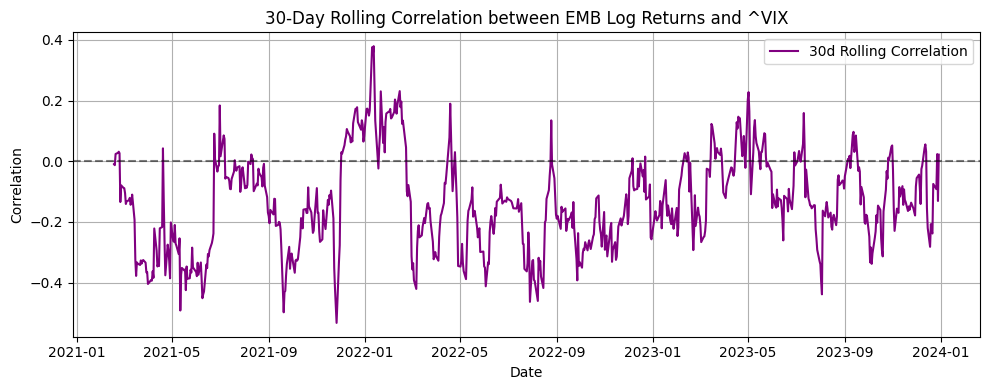

[*********************100%***********************]  1 of 1 completed

Overall correlation: -0.1457


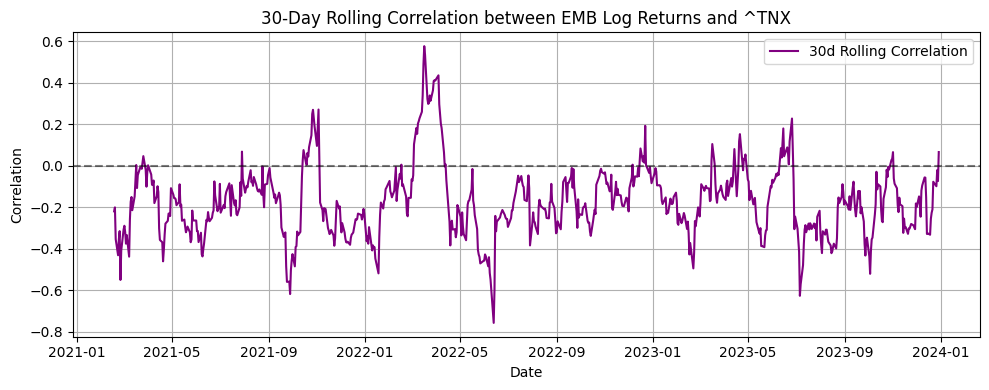

[*********************100%***********************]  1 of 1 completed

Overall correlation: 0.0275


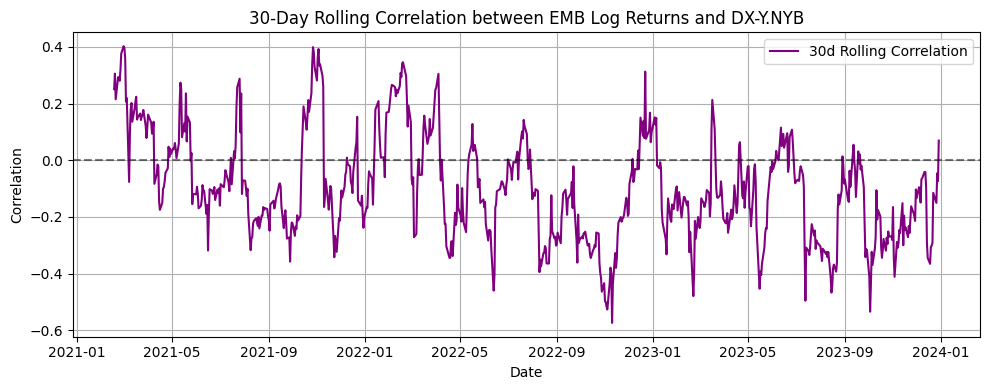

[*********************100%***********************]  1 of 1 completed

Overall correlation: -0.0027


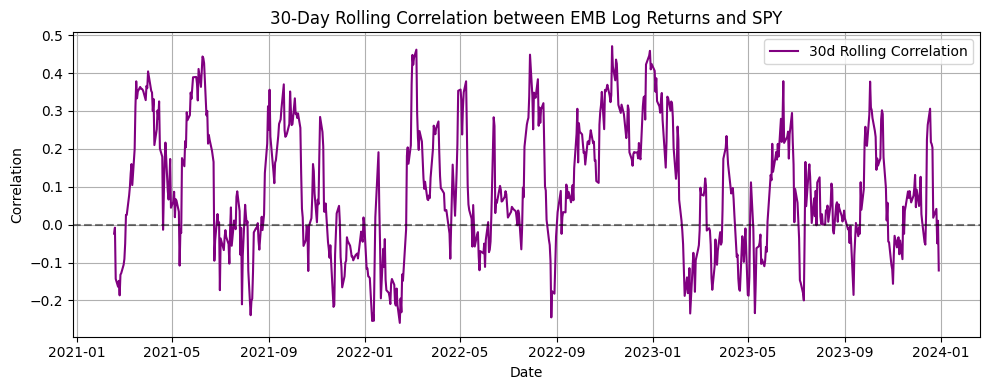

[*********************100%***********************]  1 of 1 completed

Overall correlation: 0.0501


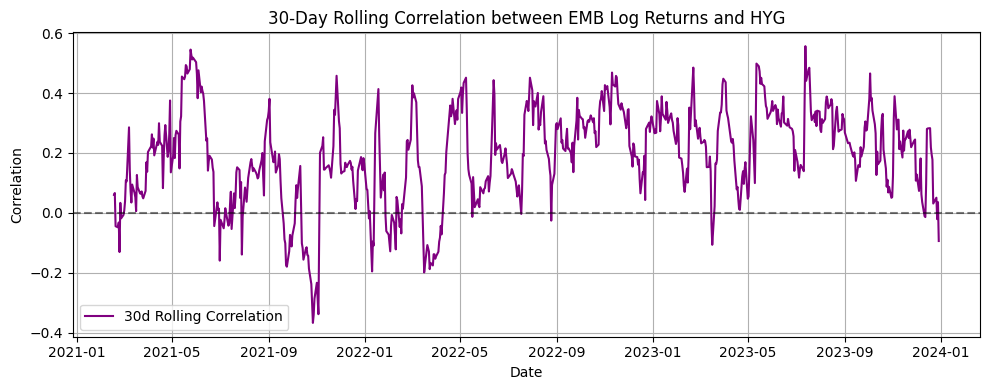

[*********************100%***********************]  1 of 1 completed

Overall correlation: 0.0539


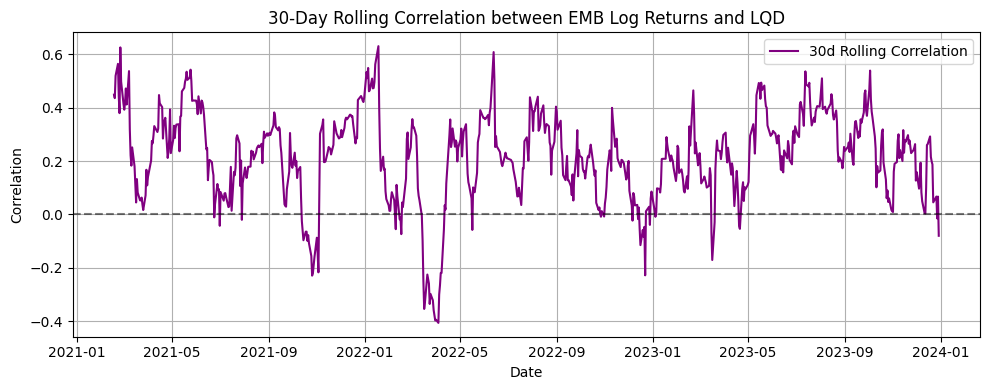

[*********************100%***********************]  1 of 1 completed

Overall correlation: 0.0033


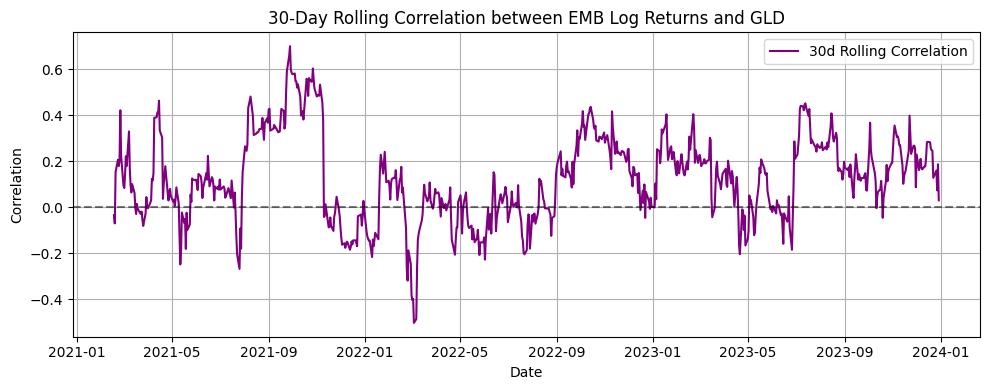

Overall correlation: 0.0552


In [85]:
names = ["^VIX","^TNX","DX-Y.NYB","SPY","HYG","LQD","GLD"]
for name_index in names:
  index_comp(name_index)

**Results**:

- VIX:\
The 30-day rolling correlation reveals a time-varying and predominantly negative association, consistent with expectations for emerging market debt instruments. Periods of elevated market stress (e.g., early 2022) correspond to stronger negative correlations, suggesting that EMB tends to sell off when VIX spikes.\
The overall correlation over the sample is modest at -0.1457, indicating a mild inverse relationship between EMB and VIX. However, the rolling dynamics highlight that this dependency is non-linear and regime-dependent, reinforcing the idea that external indicators like the VIX can be valuable features in future state classification or volatility forecasting models.
- TNX:\
Near-zero correlation, suggesting EMB returns are not linearly tied to rate changes alone — likely due to mixed credit/liquidity dynamics.
- US Dollar index:\
Virtually no static correlation; however, rolling plots show temporary spikes in negative correlation during periods of sharp USD strengthening.
- SPY:\
Very weak correlation with equity markets. EMB does not clearly follow equity cycles.
- HYG:\
Mild correlation, reflecting that both track risky debt markets. However, the relationship breaks during crises.
- LQD:\
Almost uncorrelated. EMB reflects sovereign EM risk, unlike LQD’s corporate-grade exposure.
- GLD:\
Slight positive correlation, but not persistent — suggesting EMB does not behave like a classic hedge or safe haven.

**Overall** Low and inconsistent correlations across the board imply that EMB returns are not driven by any single macro factor in a linear way.\
The rolling correlation plots show frequent shifts in direction, especially during macro shocks (e.g., mid-2022), which supports the idea that structural breaks or regime changes affect EMB dynamics.\
This provides empirical motivation for exploring Hidden Markov Models (HMMs) to segment the return series into latent states — each characterized by distinct statistical behavior.

#### Hidden Markov Model (HMM)

While GARCH-type models are effective in capturing volatility clustering and persistence, they assume a continuous and gradual evolution of volatility over time. However, financial markets often undergo abrupt regime shifts, such as transitions between low and high volatility states due to macroeconomic shocks or geopolitical events.

To better understand these structural changes, we complement our GARCH-based approach with a Hidden Markov Model (HMM), which assumes that observed log-returns are generated by a sequence of unobserved (latent) states, each associated with its own Gaussian distribution (with distinct mean and variance). The system evolves probabilistically from one state to another, according to a Markov process.

This makes HMMs ideal for uncovering latent volatility regimes rather than forecasting volatility per se.

In [52]:
X = df_emb["log_returns"].dropna().values.reshape(-1, 1)

Create model instance with n latent states, each with full covariance (not constant nor diagonal) and a maximum number of iterations:\
each of the regime is described by a normal distrubution with its own mean and variance.
_Note that_: with n > 3 the model explodes.

In [53]:
def plot_hidden_states(df_emb_hmm,hmm_model):

  n_states = df_emb_hmm["HMM_state"].nunique()
  colors = [cm.get_cmap('Dark2')(i) for i in range(n_states)] # palette

  plt.figure(figsize=(12, 4))

  for i in range(hmm_model.n_components):
      mask = df_emb_hmm["HMM_state"] == i
      plt.plot(df_emb_hmm.index[mask], df_emb_hmm["log_returns"][mask],
              '.', label=f"State {i}", alpha=0.6, markersize=4, color=colors[i])

  plt.title("Log-Returns identified by Hidden Markov States")
  plt.xlabel("Date")
  plt.ylabel("Log Returns")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [54]:
def hidden_mm(n_states=2, covariance_type="full", max_iter=1000, myseed=42, params='stmc', init_params='stmc'):

    hmm_model = GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=max_iter, random_state=myseed)
    hmm_model.fit(X)

    hidden_states = hmm_model.predict(X)

    df_emb_hmm = df_emb.copy()
    df_emb_hmm = df_emb_hmm.iloc[-len(hidden_states):]
    df_emb_hmm["HMM_state"] = hidden_states

    means = hmm_model.means_.flatten()
    variances = [np.diag(cov)[0] for cov in hmm_model.covars_]
    transition_matrix = hmm_model.transmat_

    for i in range(n_states):
        print(f"Regime {i}: mean = {means[i]:.5f}, variance = {variances[i]:.5f}")

    print("\nTransition matrix:")
    print(transition_matrix)

    plot_hidden_states(df_emb_hmm,hmm_model)

    return df_emb_hmm, hmm_model

<ipython-input-53-15cda208a1fc>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Regime 0: mean = -0.00025, variance = 0.00006
Regime 1: mean = 0.01138, variance = 0.00238

Transition matrix:
[[0.99286243 0.00713757]
 [0.98688843 0.01311157]]


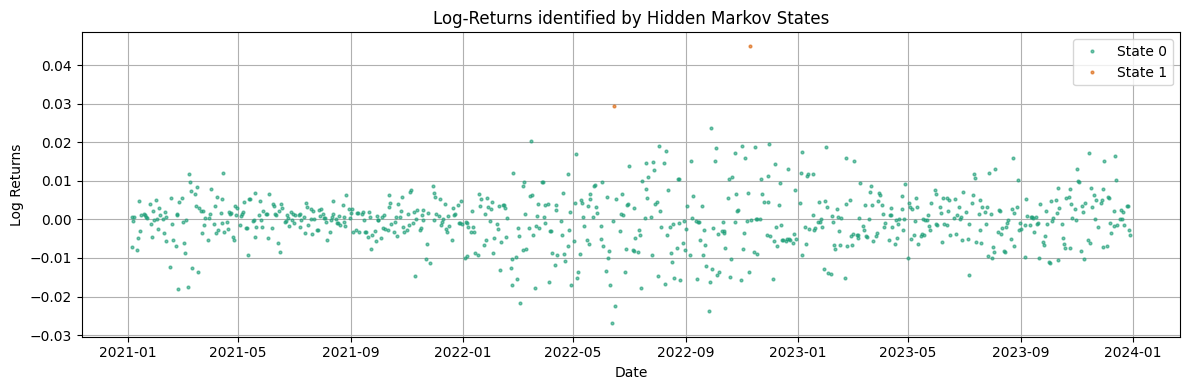

<ipython-input-53-15cda208a1fc>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Regime 0: mean = -0.00021, variance = 0.00007
Regime 1: mean = -0.00021, variance = 0.00007
Regime 2: mean = 0.00751, variance = 0.00284

Transition matrix:
[[9.09130327e-04 9.99084065e-01 6.80510274e-06]
 [9.85177018e-01 8.45905632e-03 6.36392541e-03]
 [3.84357007e-01 1.33086357e-01 4.82556636e-01]]


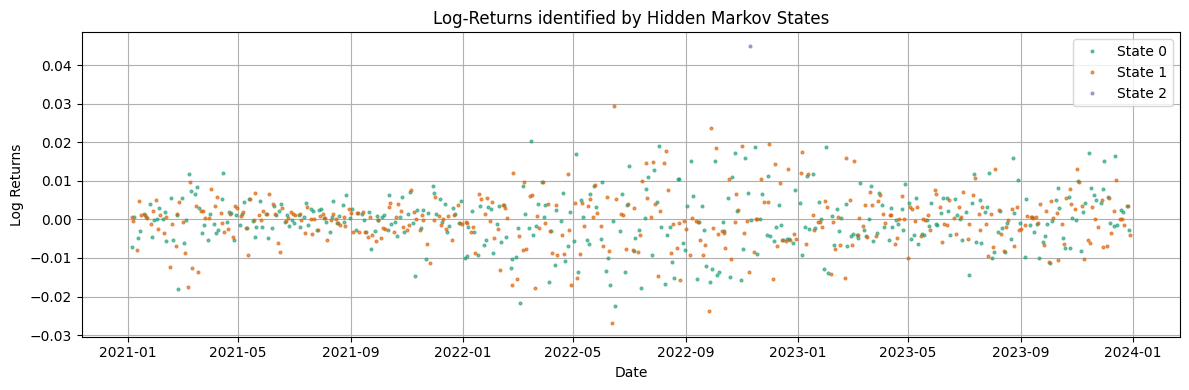

In [55]:
states = [2,3]
for state in states:
  hidden_mm(n_states=state)

The charts show log-returns classified into regimes identified by Hidden Markov Models (HMM) with 2 and 3 hidden states, respectively:

- In the 2-state HMM, we observe a clear separation:
  - State 0 corresponds to a low-volatility regime with near-zero average returns.
  - State 1 represents a high-volatility, positive-return regime, but occurs very rarely.

  The transition matrix indicates very high persistence in each state, especially in State 0, which has a self-transition probability of over 99%. This means the model tends to remain in the low-volatility regime for extended periods, with only rare switches to the high-return state.

- In the 3-state HMM, an intermediate state emerges:
  - State 0 remains a low-return, low-variance regime.
  - State 1 appears statistically similar to State 0, which may suggest redundancy.
  - State 2 captures large upward movements with high variance, akin to State 1 in the 2-state model.

  However, the model shows unstable convergence, and the transition matrix reveals complex switching dynamics, including frequent transitions between similar states (0 and 1), which may indicate overfitting or insufficient separation between regimes.

Overall, the 2-state model appears more stable and interpretable, while the 3-state model introduces noise and convergence issues without clear added value.

## Key Findings - Volatility Modeling with GARCH

Through rigorous testing and model comparison, the GARCH-t(1,2) model emerged as the best-performing volatility forecaster:

- It effectively captured the fat-tailed nature of returns via the Student-t distribution;
- It achieved the lowest MAE and RMSE in rolling 10-day forecasts;
- Forecasts were robust and consistent across multiple horizons.

Limitations of EGARCH:\
Despite its theoretical ability to capture asymmetries and leverage effects, the EGARCH(1,1) model underperformed both in-sample and out-of-sample, showing limited empirical benefits in this specific dataset.

Exploring Regime Shifts with HMM:\
To complement the continuous evolution assumed by GARCH models, a Gaussian Hidden Markov Model was used to identify latent volatility regimes:

- The 2-regime HMM separated periods of low and high volatility with clear statistical distinction;
- However, attempts to increase the number of regimes led to convergence issues and less interpretable structures;
- The transition matrix confirmed strong regime persistence, especially in low-volatility states.

**Limitations and Future Work**:

- The Gaussian assumption in the HMM is a simplification. While suitable for regime classification, it fails to capture fat tails and extreme shocks.\
Future research could explore Bayesian HMMs with t-distributed emissions (e.g., in PyMC or Stan) or mixture models as proxies.
- The project focused on univariate volatility. Extensions to multivariate models (e.g., DCC-GARCH) would allow for portfolio-level risk forecasting.
- The current approach assumes exogenous-free modeling. Incorporating macroeconomic variables or market sentiment could enhance regime detection and forecast responsiveness.
- Deep learning approaches (e.g., LSTM for volatility forecasting or sequence classification) could be explored as alternatives, although they require large datasets and additional training infrastructure.